Always show images with full resolution 

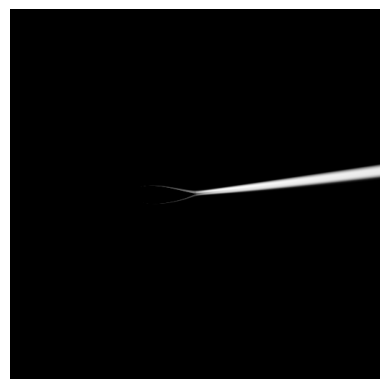

In [1]:

import os

import matplotlib.pyplot as plt
from skimage.util import img_as_float
from skimage.io import imread
from skimage.color import rgb2gray

# Define the image path
# image_path = 'airfRANS_cropped_nut.png'
image_path = "./raw_data_images/remeshed_nut.png"

# Check if the image file exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"The image file '{image_path}' does not exist.")

# show the image
img = imread(image_path, as_gray=True)
img = img_as_float(img)
plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.axis('off')  # Hide the axes
plt.show()

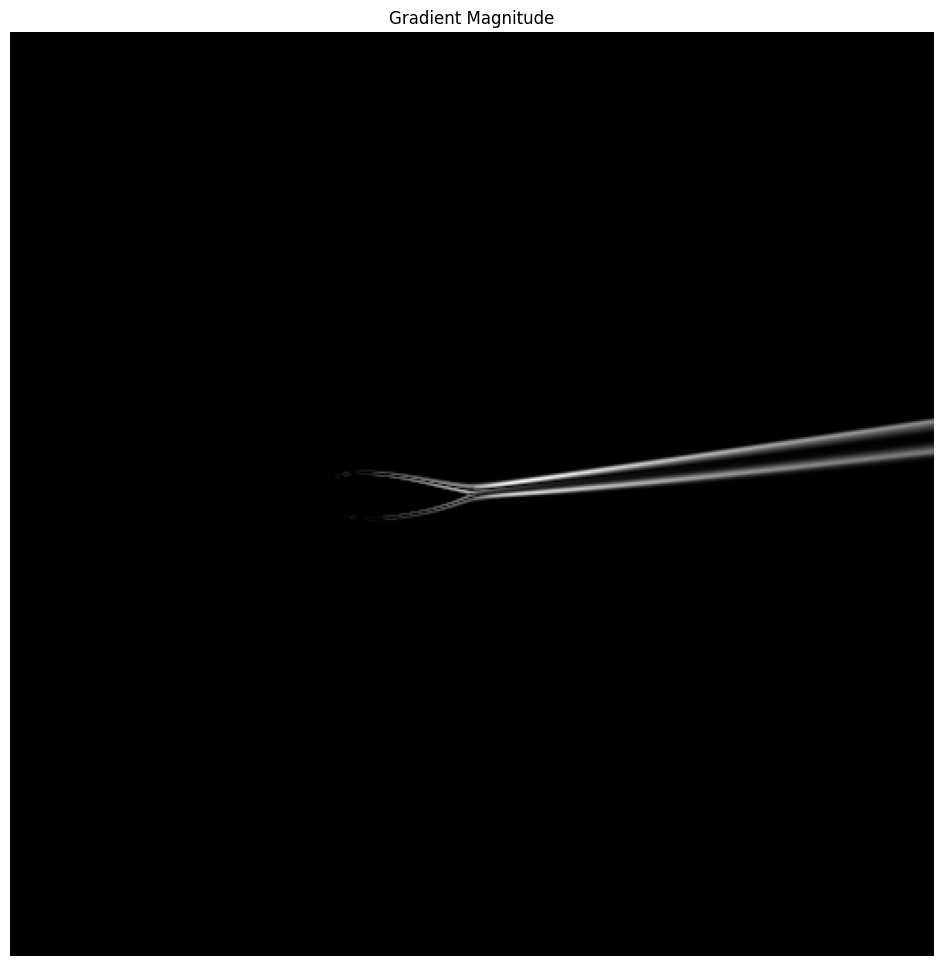

In [2]:
import numpy as np
import matplotlib.pyplot as plt
 
gx, gy = np.gradient(img)

# Compute gradient magnitude
grad_mag = np.sqrt(gx**2 + gy**2)

# Plotting gradient magnitude
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.axis('off')
ax.imshow(grad_mag, cmap='gray')
ax.set_title('Gradient Magnitude')
plt.show()



In [3]:
# calculate the gradient direction
grad_dir = np.arctan2(gy, gx)
# Plotting gradient direction
fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi= 1000)
ax.axis('off')
ax.imshow(grad_dir, cmap='gray')
ax.set_title('Gradient Direction')
plt.show()  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Angle of the tail: -6.95 degrees
Found 3 line segments.
  - Line 0: Angle = -7.88 degrees
  - Line 1: Angle = -5.93 degrees
  - Line 2: Angle = -6.00 degrees
Opening angle of the tail: -6.95 degrees


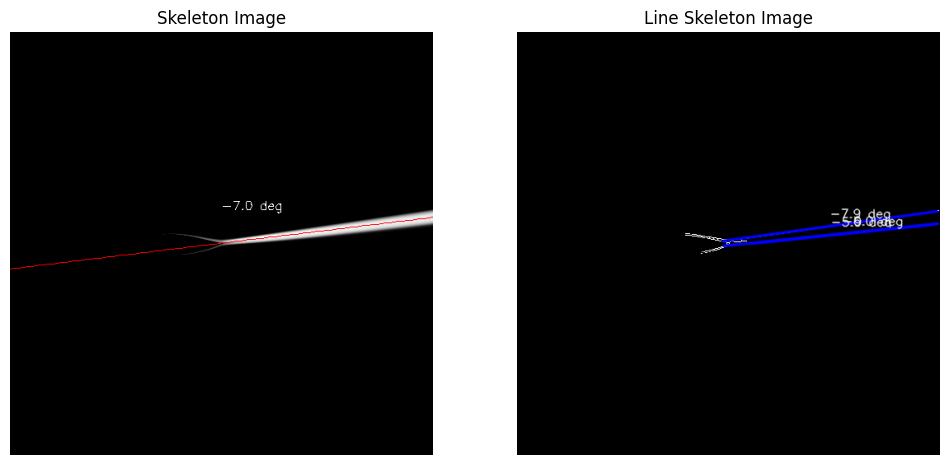

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize 
from skimage.draw import line as skimage_line

def tail_angle(img):
    """
    Calculate the angle of the tail in the image.
    
    Parameters:
    img (numpy.ndarray): The input image.
    
    Returns:
    float: The angle of the tail in degrees.
    """
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        img = rgb2gray(img)
    # Threshold the image to create a binary mask
    binary_img = img > 0.5  # Adjust threshold as needed
    
    # Skeletonize the binary image
    skeleton_image = skeletonize(binary_img)
    
    y_coords, x_coords = np.where(skeleton_image)

    if len(x_coords) > 1:
        # Fit a 1st degree polynomial (a line) to the points.
        # It returns [slope, intercept]
        slope, intercept = np.polyfit(x_coords, y_coords, 1)

        # Calculate angle from the slope
        angle = np.degrees(np.arctan(slope))
    
    # add line to the image dont plot the line
    # Draw a continuous red line by interpolating between points for smoothness

    # Create an RGB image to overlay the red line
    line_skeleton_image = np.stack([img]*3, axis=-1).astype(float)

    # Interpolate between consecutive points to fill gaps
    x_line = np.linspace(0, img.shape[1] - 1, 100)
    y_line = slope * x_line + intercept

    for i in range(len(x_line) - 1):
        x0, y0 = int(round(x_line[i])), int(round(y_line[i]))
        x1, y1 = int(round(x_line[i+1])), int(round(y_line[i+1]))
        rr, cc = skimage_line(y0, x0, y1, x1)
        rr = np.clip(rr, 0, img.shape[0] - 1)
        cc = np.clip(cc, 0, img.shape[1] - 1)
        line_skeleton_image[rr, cc, 0] = 1.0  # Red channel
        line_skeleton_image[rr, cc, 1] = 0.0  # Green channel
        line_skeleton_image[rr, cc, 2] = 0.0  # Blue channel

    # add text to the image
    text_position = (int(x1)//2, int(y0) - 10)  # Position above the point
    cv2.putText(line_skeleton_image, f"{angle:.1f} deg", 
                text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 
                (255, 255, 255), 1, cv2.LINE_AA)
    

    return skeleton_image, line_skeleton_image, angle
# here lets try     
import cv2
import math

def calculate_line_angles(binary_img):
    """
    Finds all separate line segments in a binary image using the Hough Transform
    and calculates the angle for each. This method works even if lines are connected.

    Args:
        binary_img (np.array): A binary image (0s and 255s).

    Returns:
        list: A list of dictionaries, where each dictionary contains the 'angle'
              and the 'line' coordinates (x1, y1, x2, y2).
    """
    # 1. Use the Probabilistic Hough Line Transform to find line segments.
    # Adjust minLineLength and maxLineGap for your specific use case.
    # minLineLength: Minimum length of a line in pixels. Shorter lines are rejected.
    # maxLineGap: Maximum allowed gap between points on the same line.
    lines = cv2.HoughLinesP(
        binary_img,
        rho=1,
        theta=np.pi / 180,
        threshold=15, # Minimum number of votes (intersections in Hough grid)
        minLineLength=binary_img.shape[1] * 0.4, # line should be at least 40% of the image width
        maxLineGap=10
    )
    
    line_data = []

    if lines is not None:
        # 2. Loop through each line segment found.
        for i, line_segment in enumerate(lines):
            x1, y1, x2, y2 = line_segment[0]
            
            # 3. Calculate the angle of the line segment.
            # We use atan2 for a more robust angle calculation.
            angle_rad = math.atan2(y2 - y1, x2 - x1)
            angle_deg = np.degrees(angle_rad)
            
            line_data.append({
                'id': i,
                'angle': angle_deg,
                'line': (x1, y1, x2, y2)
            })

    return line_data

#morphological into binary image
from skimage.filters import threshold_otsu
def tail_opening_angle(img):
    """
    Calculate the opening angle of the tail in the image.
    
    Parameters:
    img (numpy.ndarray): The input image.
    
    Returns:
    float: The opening angle of the tail in degrees.
    """
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        img = rgb2gray(img)

    gx, gy = np.gradient(img)

    # Compute gradient magnitude
    grad_mag = np.sqrt(gx**2 + gy**2)

    thresh = threshold_otsu(grad_mag)
    binary_grad_mag = grad_mag > thresh 

    skeleton_grad_image = skeletonize(binary_grad_mag) 
 
    img_unit8 = (skeleton_grad_image * 255).astype(np.uint8)

    # 2. Calculate the angles of all lines in the image.
    detected_lines = calculate_line_angles(img_unit8)
    
    # 3. Visualize the results.
    # Create a color image to draw the results on.
    output_image = cv2.cvtColor(img_unit8, cv2.COLOR_GRAY2BGR)
    
    if detected_lines:
        print(f"Found {len(detected_lines)} line segments.")
        for line in detected_lines:
            # Generate a random color for each line for better visualization
            color = np.random.randint(50, 255, size=3).tolist()
            
            # Draw the detected line segment in solid red, thickness=2 (anti-aliased)
            x1, y1, x2, y2 = line['line']
            cv2.line(output_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2, lineType=cv2.LINE_AA)
            
            # Put the calculated angle as text near the center of the line
            centroid_x, centroid_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
            text = f"{line['angle']:.1f} deg"
            cv2.putText(output_image, text, (centroid_x, centroid_y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            print(f"  - Line {line['id']}: Angle = {line['angle']:.2f} degrees")

    return output_image, angle
 

# height, width = img.shape
# half_width = width // 2
# cropped_img = img[:, half_width:] 

# Call the function to get the skeleton image and angle
skeleton_image, line_skeleton_image, angle = tail_angle(img)
print(f"Angle of the tail: {angle:.2f} degrees") 

tail_opening_image, angle = tail_opening_angle(img)
print(f"Opening angle of the tail: {angle:.2f} degrees")

# Display the skeleton image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(line_skeleton_image)
ax[0].axis('off')
ax[0].set_title('Skeleton Image')   
ax[1].imshow(tail_opening_image)
ax[1].axis('off')
ax[1].set_title('Line Skeleton Image')
plt.show()

# Below is experimental

Found 3 contours in the binary image.
Found 3 line segments in the contour.


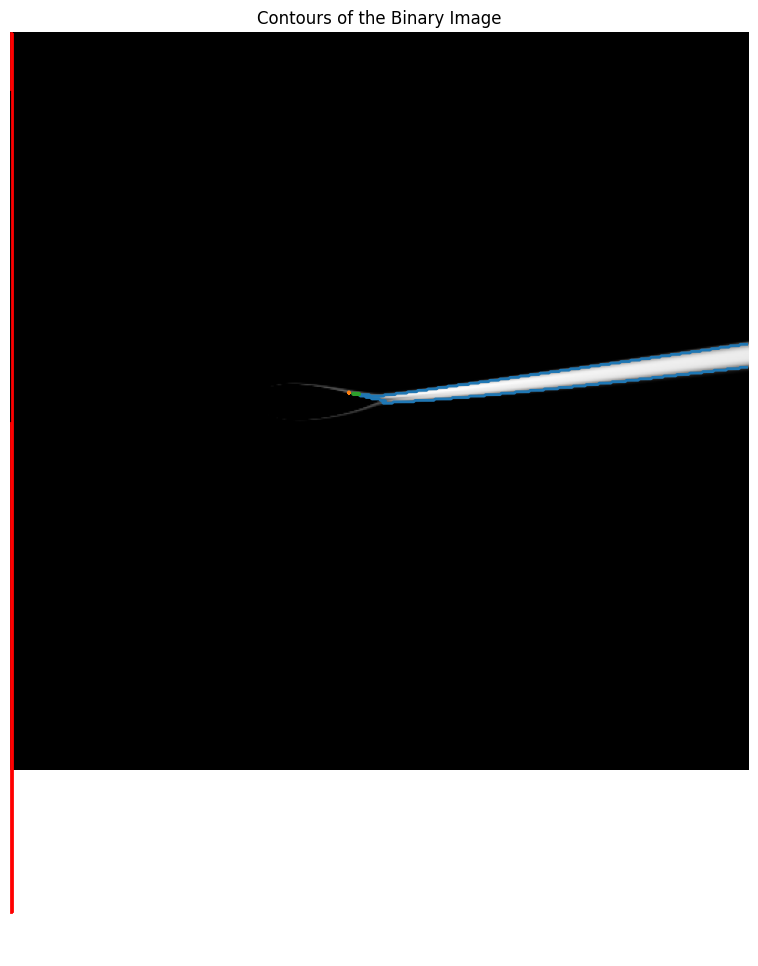

In [13]:
# threshold the image to create a binary mask
binary_img = img > 0.4  # Adjust threshold as needed
# make a contour of the binary image
from skimage.measure import find_contours
contours = find_contours(binary_img, 0.5)
# Convert contours to a list of numpy arrays
contours = [np.array(contour) for contour in contours]
print(f"Found {len(contours)} contours in the binary image.")
line_data = calculate_line_angles(contours[0].astype(np.uint8) * 255)  # Use the first contour for line angle calculation
print(f"Found {len(line_data)} line segments in the contour.")
# Plot the contours on the original image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img, cmap='gray', vmin=0, vmax=1)
#draw line_data
for line in line_data:
    x1, y1, x2, y2 = line['line']
    ax.plot([x1, x2], [y1, y2], color='red', linewidth=2)  # Draw the line in red
# Draw the contours
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)  # Note: contour[:, 1] is x, contour[:, 0] is y
ax.axis('off')  # Hide the axes
ax.set_title('Contours of the Binary Image')
plt.show()

In [29]:
# --- Reduce Gray Depth (Quantization) ---
def quantize_image(image, num_levels = 8):
    """
    Quantizes the input image to a specified number of gray levels.
    
    Parameters:
    - image: Input grayscale image (2D numpy array).
    - num_levels: Number of desired gray levels.
    
    Returns:
    - quantized_image: Quantized image with reduced gray levels.
    """ 
    # Create a copy to work with
    quantized_img = image.copy()

    # Get the min and max values of the actual masked area (ignoring the white background)
    min_val = quantized_img.min()
    max_val = quantized_img.max()

    # Apply quantization only to the masked area
    if max_val > min_val:
        # Normalize the masked area to a 0-1 range
        normalized_masked_area = (quantized_img.astype(np.float32) - min_val) / (max_val - min_val)
        
        # Quantize to the desired number of levels
        quantized_masked_area = np.floor(normalized_masked_area * (num_levels - 1))
        
        # Scale the quantized values back to the original 0-255 range
        rescaled_masked_area = (quantized_masked_area / (num_levels - 1)) * 255
        
        # Place the rescaled area back into the image
        quantized_img = rescaled_masked_area.astype(np.uint8)
        #normalize to 0.0 - 1.0
        quantized_img = quantized_img / 255.0
    return quantized_img
 
# round the intensity values to 3 decimal places
rounded_masked_img = quantize_image(masked_img, 20)
# # Plotting the quantized image
# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# ax.axis('off')
# ax.imshow(rounded_masked_img, cmap='gray')
# ax.set_title('Quantized Image')
# plt.show()

In [64]:
# Skeletonization using morphological operations
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import find_contours
from rdp import rdp
unique_intensities = np.unique(rounded_masked_img)
print(f"Unique intensity values found: {len(unique_intensities)}")

combined_skeleton_image = np.zeros_like(rounded_masked_img, dtype=bool)

print(f"Found {len(unique_intensities)} unique intensity values.")
path_datas = []
# Loop through each unique intensity value
for i, intensity_value in enumerate(unique_intensities):   
    
    binary_mask = (rounded_masked_img == intensity_value)
    
    skeleton = skeletonize(binary_mask, )
    # save each skeleton as image in a folder for debugging
    skeleton_image_path = f'skeleton/skeleton_{intensity_value}.png'
    plt.imsave(skeleton_image_path, skeleton, cmap='gray')
    # Find contours in the skeleton image
    contours = find_contours(skeleton, 0.5, fully_connected='high')
    # Add the contours to the SVG drawing as paths
    for contour in contours:
        simplified_contour = rdp(contour, epsilon=2)
        if len(simplified_contour) > 1:
            # Convert the contour to a series of (x, y) coordinates
            path_data = "M " + " L ".join(f"{x},{y}" for y, x in simplified_contour) + " Z"
            path_datas.append(path_data)

    combined_skeleton_image = np.logical_or(combined_skeleton_image, skeleton)
    
    if (i + 1) % 20 == 0 or (i + 1) == len(unique_intensities): # Print progress
        print(f"Processed skeleton for intensity value {intensity_value} ({i+1}/{len(unique_intensities)})")

# use masked_img as mask to remove the skeletons from the background
combined_skeleton_image = combined_skeleton_image * mask

# Plotting the combined skeleton image
fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=1000)
ax.imshow(combined_skeleton_image.astype(float), cmap='gray')
ax.set_title('Combined Skeletons from Unique Intensity Layers')
ax.axis('off')
plt.show() 

Unique intensity values found: 20
Found 20 unique intensity values.
Processed skeleton for intensity value 1.0 (20/20)


ValueError: operands could not be broadcast together with shapes (513,513) (750,1500) 

Starting path tracing. Start point: (500.00, 372.00), Mask at start: 255

Iteration 0:
  Current point: (500.00, 372.00), Smoothed Distance: 0.7140
  Interpolated gx=0.0420, gy=0.3037
  Gradient magnitude: 0.3066
  Test point1: (499.90, 372.01), dist_val1: 0.6536
  Test point2: (500.10, 371.99), dist_val2: 0.6551
  Chosen flow vector (normalized): (0.99, -0.14)
  Calculated next_point: (500.10, 371.99)
  Smoothed distance at next_point: 0.6551

Iteration 1:
  Current point: (500.10, 371.99), Smoothed Distance: 0.6551
  Interpolated gx=0.0072, gy=0.2437
  Gradient magnitude: 0.2438
  Test point1: (500.00, 371.99), dist_val1: 0.7077
  Test point2: (500.20, 371.98), dist_val2: 0.6022
  Chosen flow vector (normalized): (-1.00, 0.03)
  Calculated next_point: (500.00, 371.99)
  Smoothed distance at next_point: 0.7077

Iteration 2:
  Current point: (500.00, 371.99), Smoothed Distance: 0.7077
  Interpolated gx=0.0455, gy=0.3035
  Gradient magnitude: 0.3069
  Test point1: (499.90, 372.00), dist

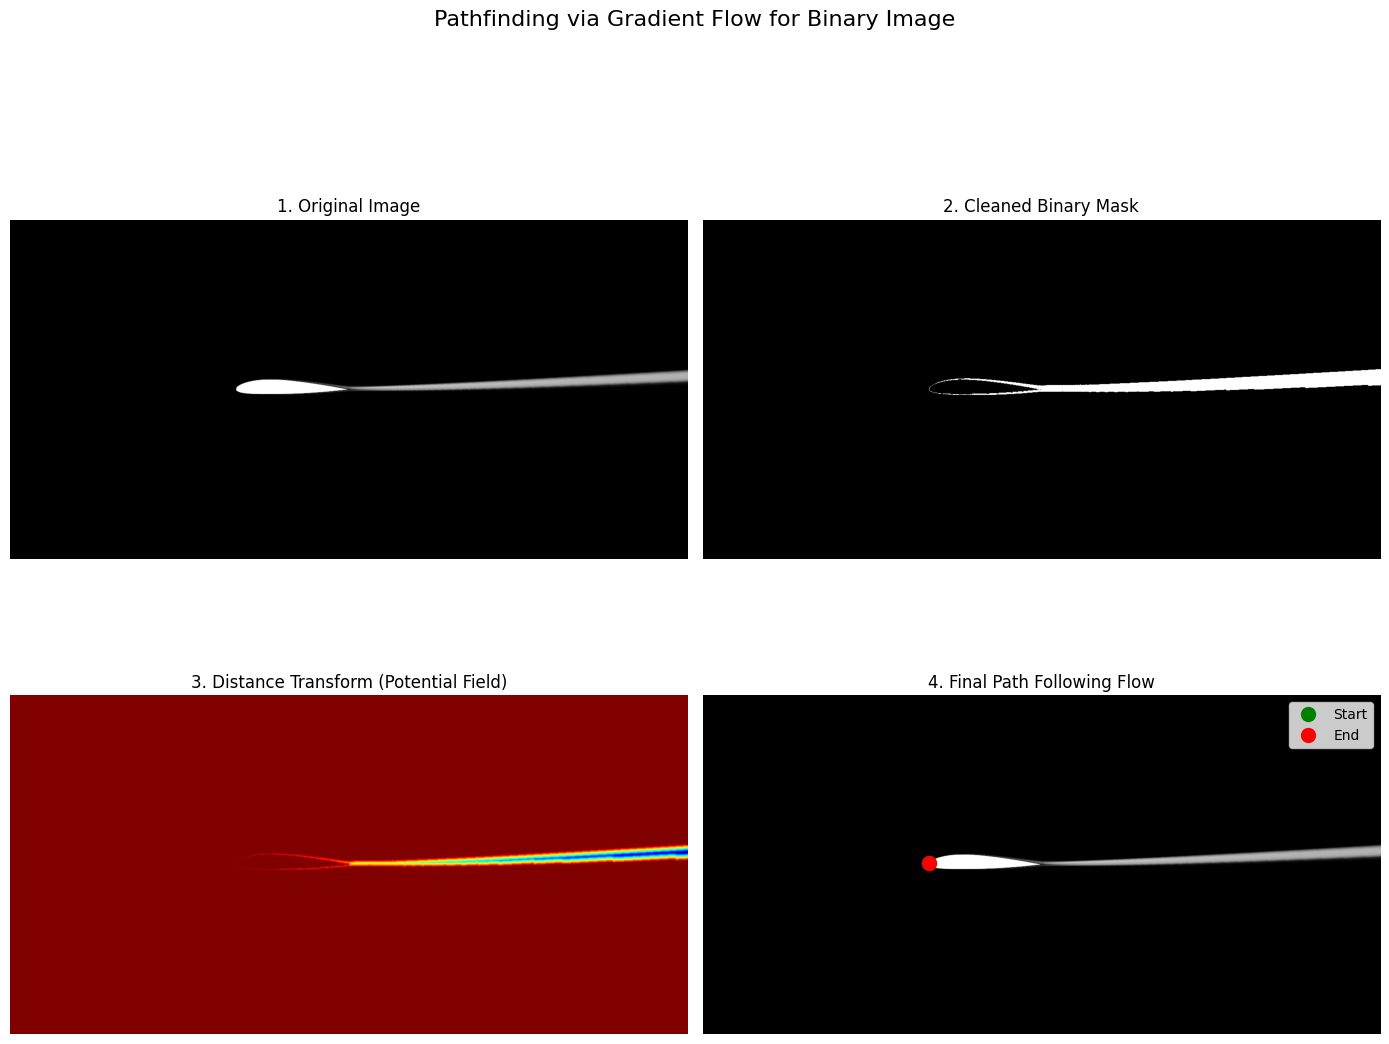

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator

def find_flow_path(image_path, step_size=1.0, max_steps=5000): # Increased max_steps
    """
    Finds and visualizes a flow path through a shape in a binary image.

    The path is calculated by following streamlines perpendicular to the gradient
    of the distance transform of the shape.

    Args:
        image_path (str): Path to the input binary image file.
                          Can be 8-bit (0-255) or float (0.0-1.0).
        step_size (float): How far to move in each iteration of path tracing.
        max_steps (int): Maximum number of steps to prevent infinite loops.

    Returns:
        tuple: A tuple containing visualization images and the calculated path.
               (original_img_rgb, mask, dist_transform_visual, path)
    """
    # --- 1. Load Image and Create Standardized Binary Mask ---
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image at {image_path}")

    if img.dtype == np.float32 or img.dtype == np.float64:
        img = (img * 255).astype(np.uint8)
    
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    boolean_mask = (img != 255) & (img != 0)
    mask = boolean_mask.astype(np.uint8) * 255
    original_img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # --- 2. Compute Distance Transform and its Gradient ---
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    smoothed_dist = gaussian_filter(dist_transform, sigma=0.5) # Reduced sigma to 0.5
    grad_y, grad_x = np.gradient(smoothed_dist)
    height, width = mask.shape

    # --- 3. Find Optimal Starting Point (Robustly) ---
    start_col = -1
    for col in range(width):
        if np.any(mask[:, col] > 0):
            start_col = col
            break
    if start_col == -1:
        print("Warning: No shape found anywhere in the image.")
        return original_img_rgb, mask, dist_transform, []
    start_col_indices = np.where(mask[:, start_col] > 0)[0]
    start_y = start_col_indices[np.argmax(dist_transform[start_col_indices, start_col])]
    start_point = np.array([float(start_col), float(start_y)])

    # --- 4. Trace the Path (Streamline Following) ---
    path = [start_point]
    current_point = start_point.copy()
    print(f"Starting path tracing. Start point: ({start_point[0]:.2f}, {start_point[1]:.2f}), Mask at start: {mask[int(round(start_point[1])), int(round(start_point[0]))]}")
    
    x_coords = np.arange(width)
    y_coords = np.arange(height)
    interp_dist = RegularGridInterpolator((y_coords, x_coords), smoothed_dist, method='linear', bounds_error=False, fill_value=None)
    interp_grad_x = RegularGridInterpolator((y_coords, x_coords), grad_x, method='linear', bounds_error=False, fill_value=None)
    interp_grad_y = RegularGridInterpolator((y_coords, x_coords), grad_y, method='linear', bounds_error=False, fill_value=None)

    # Define a threshold for smoothed distance to consider a point "outside"
    distance_threshold = 1e-3

    for i in range(max_steps):
        point_yx = np.array([current_point[1], current_point[0]])
        current_smoothed_dist_val = interp_dist(point_yx).item()
        
        # Adjusted print condition for better diagnostics
        print_this_iter = (i < 10) or (i % 200 == 0 and i < max_steps - 200) or (i >= max_steps - 10)

        if print_this_iter:
            print(f"\nIteration {i}:")
            print(f"  Current point: ({current_point[0]:.2f}, {current_point[1]:.2f}), Smoothed Distance: {current_smoothed_dist_val:.4f}")

        gx = interp_grad_x(point_yx).item()
        gy = interp_grad_y(point_yx).item()
        if print_this_iter:
            print(f"  Interpolated gx={gx:.4f}, gy={gy:.4f}")

        if gx is None or gy is None or np.isnan(gx) or np.isnan(gy):
            print(f"  Iteration {i}: Breaking - Invalid gradient (None or NaN). gx={gx}, gy={gy}")
            break
            
        mag = np.sqrt(gx**2 + gy**2)
        if print_this_iter:
            print(f"  Gradient magnitude: {mag:.4f}")

        if mag < 1e-6:
            print(f"  Iteration {i}: Breaking - Gradient magnitude too small ({mag:.4e}).")
            break

        perp_vec1 = np.array([-gy, gx]) / mag
        perp_vec2 = np.array([gy, -gx]) / mag

        test_point1 = current_point + step_size * perp_vec1
        test_point2 = current_point + step_size * perp_vec2

        dist_val1 = interp_dist((test_point1[1], test_point1[0])).item()
        dist_val2 = interp_dist((test_point2[1], test_point2[0])).item()
        if print_this_iter:
            print(f"  Test point1: ({test_point1[0]:.2f}, {test_point1[1]:.2f}), dist_val1: {dist_val1:.4f}")
            print(f"  Test point2: ({test_point2[0]:.2f}, {test_point2[1]:.2f}), dist_val2: {dist_val2:.4f}")

        if dist_val1 > dist_val2:
            flow_vec_normalized = perp_vec1
        else:
            flow_vec_normalized = perp_vec2
        if print_this_iter:
            print(f"  Chosen flow vector (normalized): ({flow_vec_normalized[0]:.2f}, {flow_vec_normalized[1]:.2f})")
        
        next_point = current_point + step_size * flow_vec_normalized
        if print_this_iter:
             print(f"  Calculated next_point: ({next_point[0]:.2f}, {next_point[1]:.2f})")
        
        # Check if out of bounds first
        next_y_int_check, next_x_int_check = int(round(next_point[1])), int(round(next_point[0]))
        if not (0 <= next_y_int_check < height and 0 <= next_x_int_check < width):
            print(f"  Iteration {i}: Breaking - Next point ({next_x_int_check}, {next_y_int_check}) is out of image bounds (width={width}, height={height}).")
            break

        # New boundary check based on smoothed distance
        next_point_dist_val = interp_dist((next_point[1], next_point[0])).item()
        if print_this_iter:
            print(f"  Smoothed distance at next_point: {next_point_dist_val:.4f}")
        if next_point_dist_val < distance_threshold:
            print(f"  Iteration {i}: Breaking - Next point's smoothed distance ({next_point_dist_val:.4f}) is below threshold ({distance_threshold:.4e}).")
            break

        path.append(next_point)
        current_point = next_point

        if current_point[0] >= width - (1 + step_size): # Adjusted exit condition for width
            print(f"  Iteration {i}: Path reached near the right edge of the image.")
            break
    
    if i < max_steps - 1 and len(path) > 1:
        print(f"Path tracing stopped after {len(path)-1} successful steps. Last point: ({current_point[0]:.2f}, {current_point[1]:.2f})")
    elif len(path) == 1:
        print(f"Path tracing loop did not add any points after the start point. Loop ran for {i+1} iteration(s) but broke.")
    else:
        print(f"Path tracing completed {len(path)-1} steps. Last point: ({current_point[0]:.2f}, {current_point[1]:.2f})")

    dist_transform_visual = cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    dist_transform_visual = cv2.applyColorMap(dist_transform_visual, cv2.COLORMAP_JET)

    return original_img_rgb, mask, dist_transform_visual, path


try:
    image_path = 'airfRANS_cropped_nut.png' # Ensure image_path is defined
    original, mask, dist_transform_img, path = find_flow_path(image_path, step_size=0.1) 
    print(f"Path generated with {len(path)} points.")

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Pathfinding via Gradient Flow for Binary Image', fontsize=16)

    axes[0, 0].imshow(original)
    axes[0, 0].set_title('1. Original Image')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('2. Cleaned Binary Mask')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(dist_transform_img)
    axes[1, 0].set_title('3. Distance Transform (Potential Field)')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(original)
    if len(path) > 1:
        path_np = np.array(path)
        axes[1, 1].plot(path_np[:, 0], path_np[:, 1], color='yellow', linewidth=2.5, linestyle='--')
        axes[1, 1].plot(path_np[0, 0], path_np[0, 1], 'go', markersize=10, label='Start')
        axes[1, 1].plot(path_np[-1, 0], path_np[-1, 1], 'ro', markersize=10, label='End')
        axes[1, 1].legend() # Call legend only if labels were added
    axes[1, 1].set_title('4. Final Path Following Flow')
    axes[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
    print(f"Please make sure '{image_path}' is in the same directory as the script.")
except AttributeError as e:
    print(f"An AttributeError occurred: {e}")
    print("This might be due to an issue with how the path is being handled or plotted.")
    print(f"Current path data: {path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    # print(f"Path data at time of error: {path}") # Path might not be defined here